In [47]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import shap

In [27]:
# Load Dataset
df = pd.read_csv("/content/enhanced_fever_medicine_recommendation.csv")

# Data Overview
df.head()
df.describe()

,Temperature,Age,BMI,Humidity,AQI,Heart_Rate
count,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,38.09890,51.152000,26.44320,60.594400,248.493000,80.14400
std,1.13887,28.873354,4.90115,17.058475,143.705244,11.79196
min,36.00000,1.000000,18.00000,30.000000,0.000000,60.00000
25%,37.20000,26.000000,22.40000,46.600000,127.750000,70.00000
50%,38.20000,51.000000,26.50000,60.950000,247.500000,80.00000
75%,39.10000,76.000000,30.52500,74.725000,375.250000,90.00000
max,40.00000,100.000000,35.00000,90.000000,499.000000,100.00000


In [28]:
# Checking for Null and Duplicated Data
print(df.isnull().sum())
print(df.duplicated().value_counts())

Temperature                 0
Fever_Severity              0
Age                         0
Gender                      0
BMI                         0
Headache                    0
Body_Ache                   0
Fatigue                     0
Chronic_Conditions          0
Allergies                   0
Smoking_History             0
Alcohol_Consumption         0
Humidity                    0
AQI                         0
Physical_Activity           0
Diet_Type                   0
Heart_Rate                  0
Blood_Pressure              0
Previous_Medication       237
Recommended_Medication      0
dtype: int64
False    1000
Name: count, dtype: int64


In [29]:
# Remove Null Data
df = df.dropna()
print(df.isnull().sum())

Temperature               0
Fever_Severity            0
Age                       0
Gender                    0
BMI                       0
Headache                  0
Body_Ache                 0
Fatigue                   0
Chronic_Conditions        0
Allergies                 0
Smoking_History           0
Alcohol_Consumption       0
Humidity                  0
AQI                       0
Physical_Activity         0
Diet_Type                 0
Heart_Rate                0
Blood_Pressure            0
Previous_Medication       0
Recommended_Medication    0
dtype: int64


In [30]:
# Handle Categorical Columns
categorical_cols = df.select_dtypes(include='object').columns

# Check distribution of categorical columns
for col in categorical_cols:
    print(f"{col}:\n{df[col].value_counts()}\n")

Fever_Severity:
Fever_Severity
High Fever    411
Normal        202
Mild Fever    150
Name: count, dtype: int64

Gender:
Gender
Male      385
Female    378
Name: count, dtype: int64

Headache:
Headache
Yes    392
No     371
Name: count, dtype: int64

Body_Ache:
Body_Ache
Yes    399
No     364
Name: count, dtype: int64

Fatigue:
Fatigue
No     382
Yes    381
Name: count, dtype: int64

Chronic_Conditions:
Chronic_Conditions
Yes    409
No     354
Name: count, dtype: int64

Allergies:
Allergies
No     398
Yes    365
Name: count, dtype: int64

Smoking_History:
Smoking_History
Yes    382
No     381
Name: count, dtype: int64

Alcohol_Consumption:
Alcohol_Consumption
Yes    400
No     363
Name: count, dtype: int64

Physical_Activity:
Physical_Activity
Active       276
Sedentary    247
Moderate     240
Name: count, dtype: int64

Diet_Type:
Diet_Type
Non-Vegetarian    265
Vegan             250
Vegetarian        248
Name: count, dtype: int64

Blood_Pressure:
Blood_Pressure
High      264
Normal    

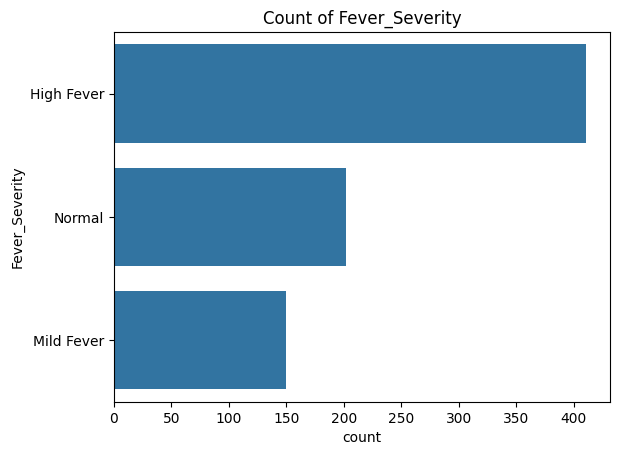

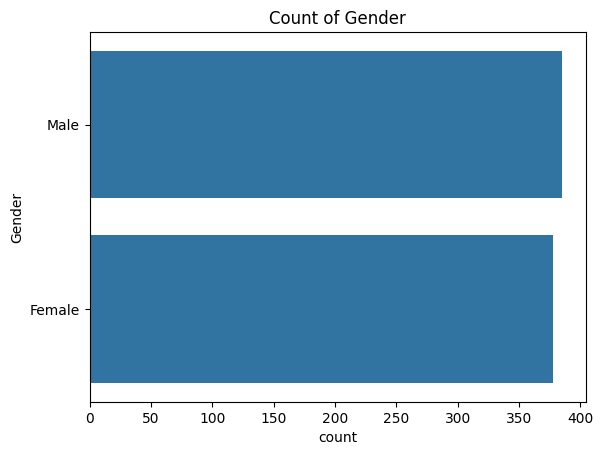

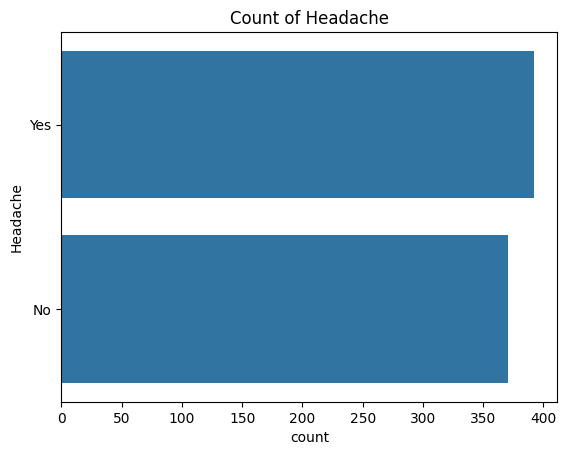

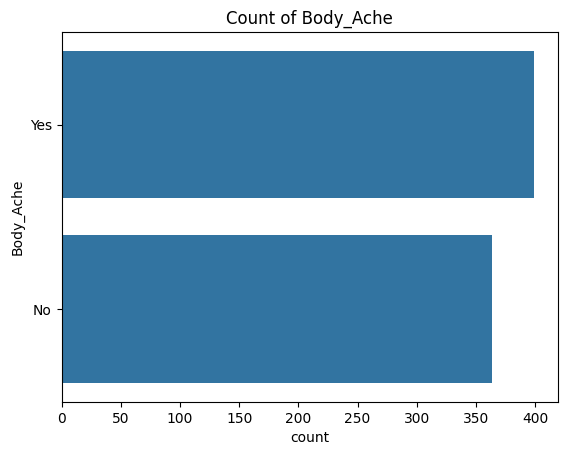

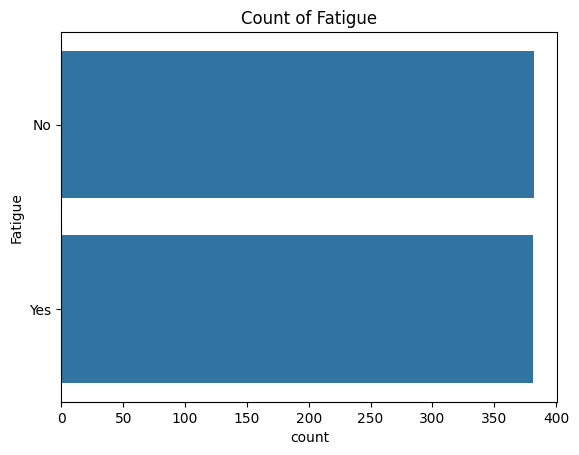

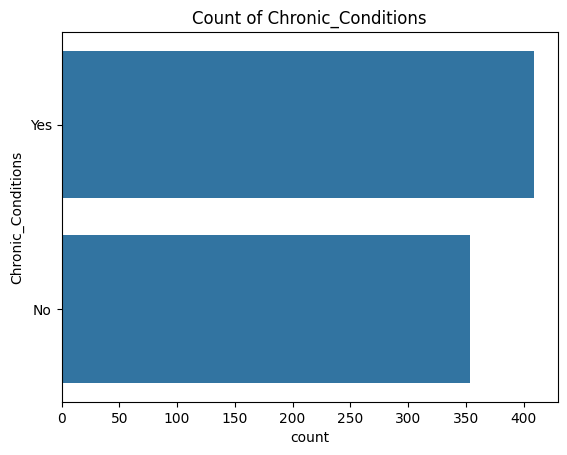

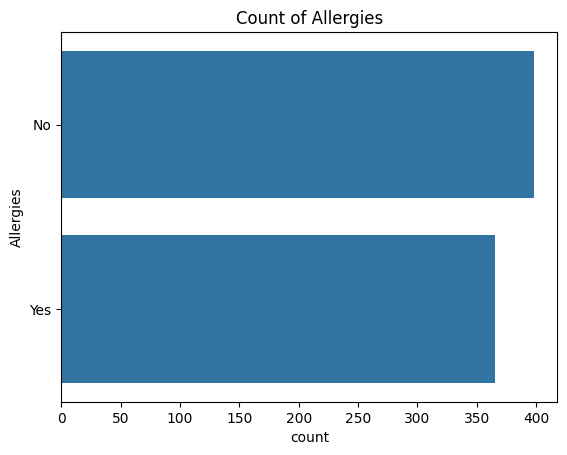

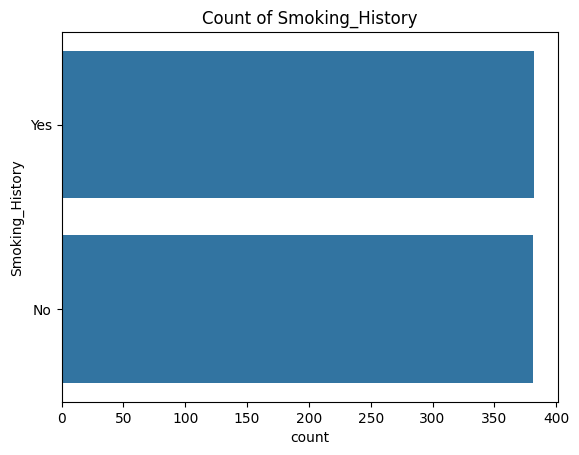

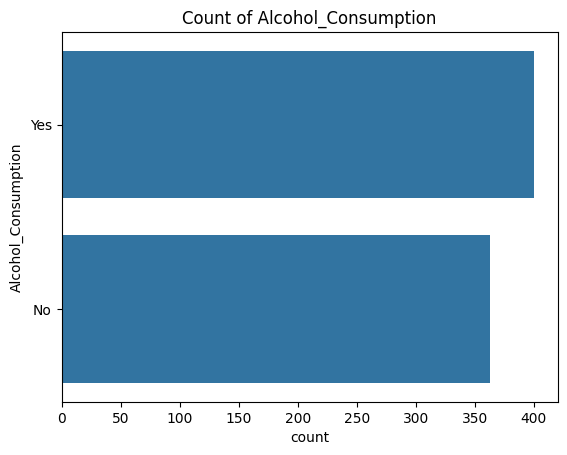

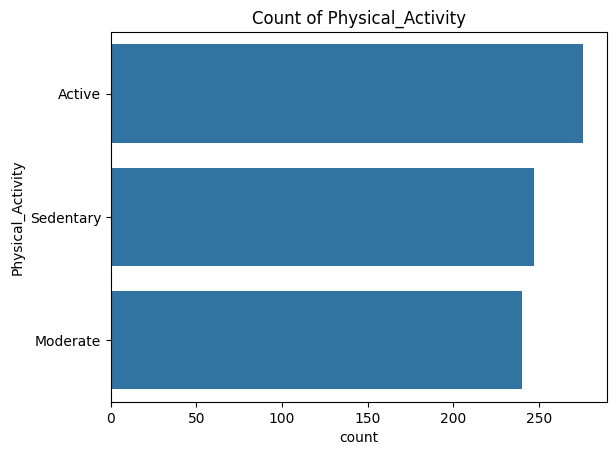

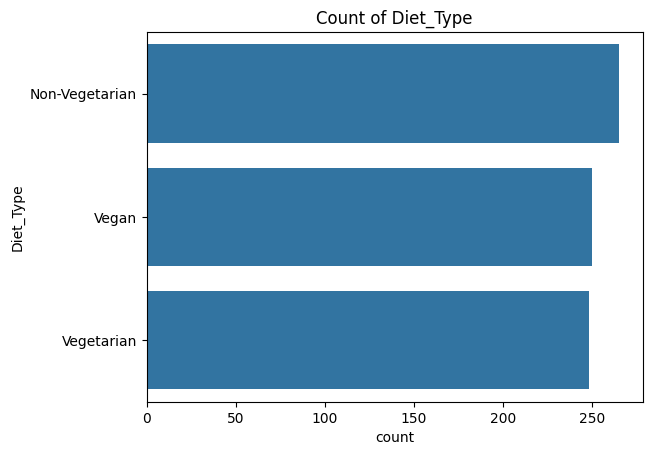

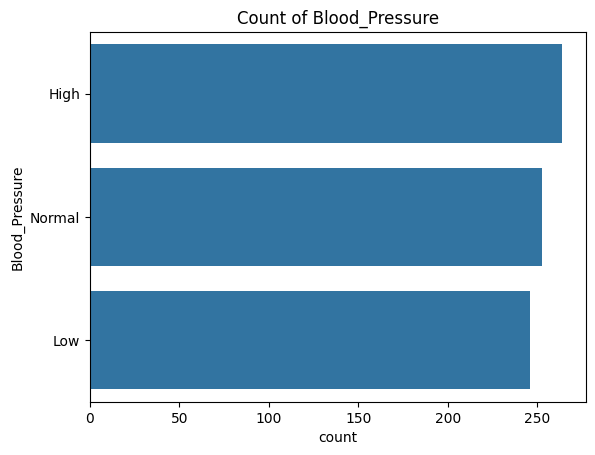

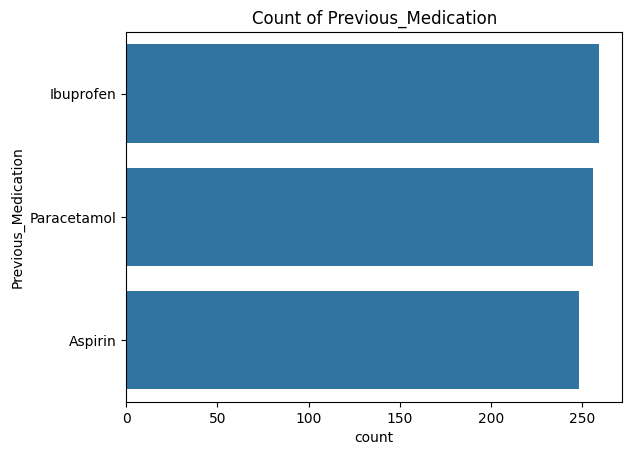

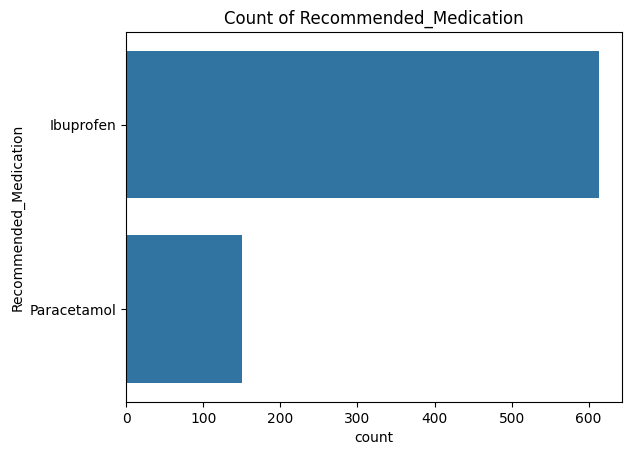

In [31]:
# Plot distribution of categorical features
for col in categorical_cols:
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.show()

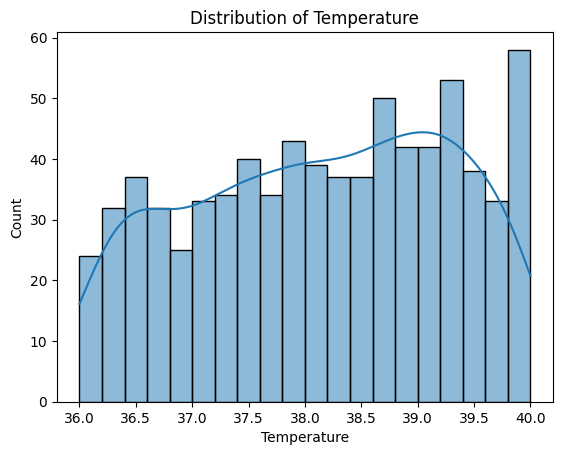

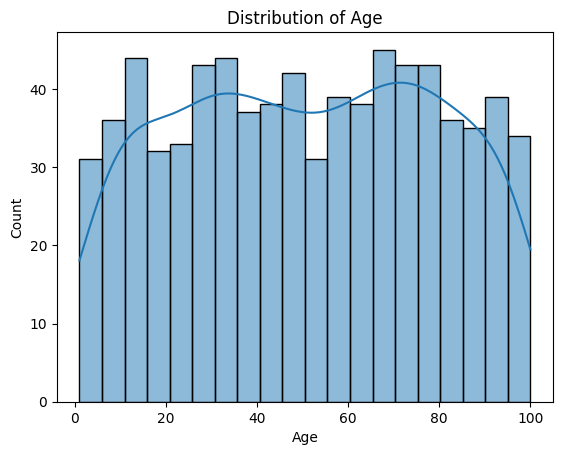

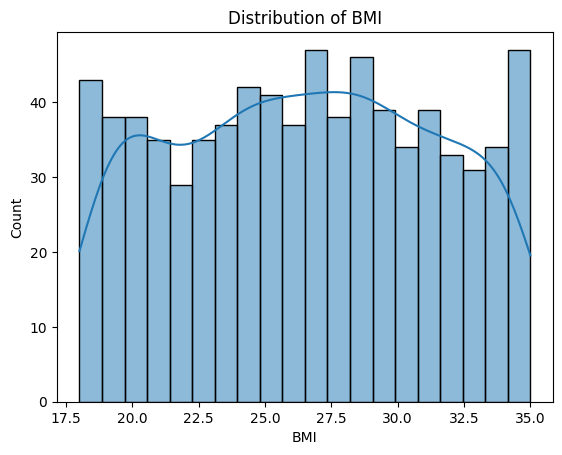

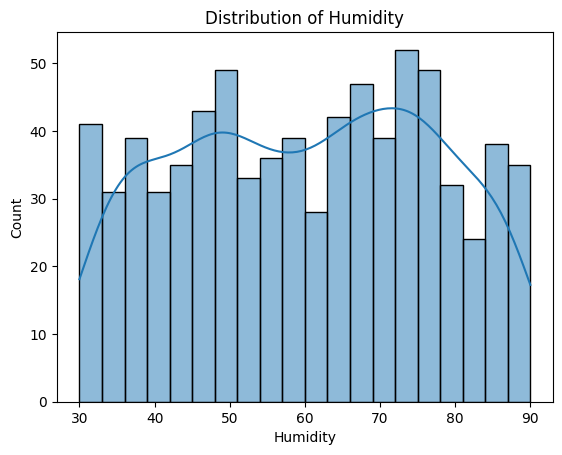

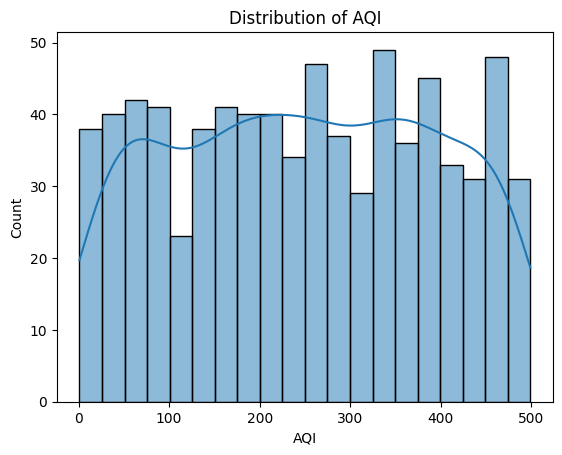

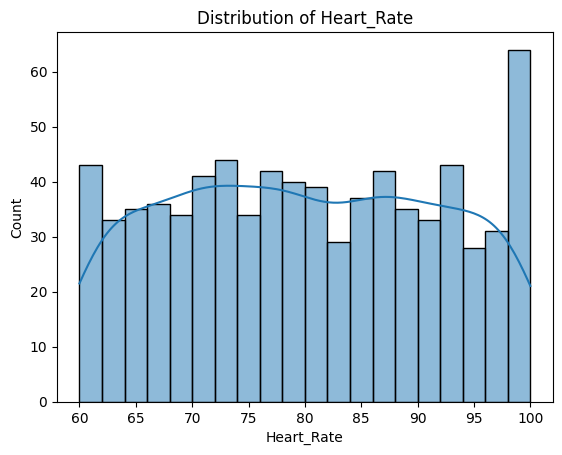

In [32]:
# Plot distribution of numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.show()

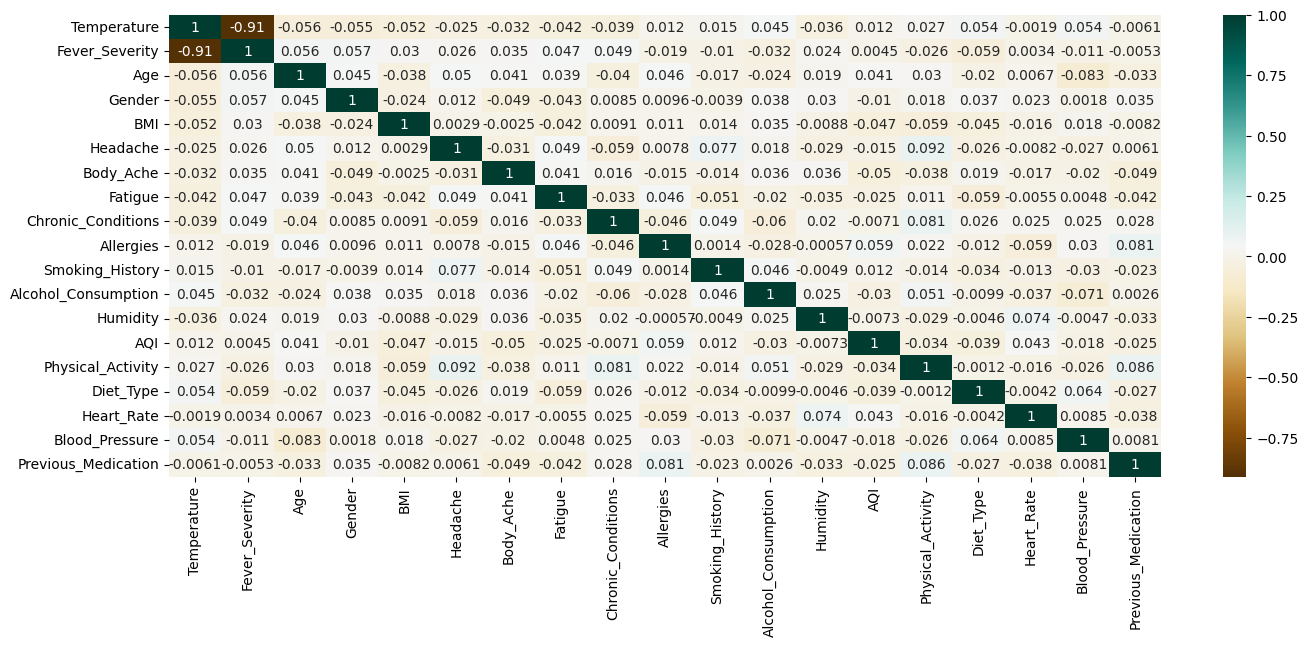

In [33]:
# Encoding categorical features to numeric values
le = LabelEncoder()

def enkod(df, kolom):
    df[kolom] = le.fit_transform(df[kolom])

for kolom in df.select_dtypes(include=['object']).columns:
    enkod(df, kolom)

# Correlation heatmap to check relationships between features
plt.figure(figsize=(16, 6))
korelasi = df.drop(["Recommended_Medication"], axis=1).corr()
sns.heatmap(korelasi, cmap="BrBG", annot=True)

# Dimensionality Reduction using PCA with 5 components
X = df.drop(["Recommended_Medication"], axis=1)
y = df["Recommended_Medication"]

pca = PCA(n_components=5)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

In [58]:
# Apply PCA to scaled data
new_x = pca.fit_transform(x_scaled)

# Train-Test Split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(new_x, y, test_size=0.3, random_state=42)

# Encode target for NN
y_nn = le.fit_transform(y)  # Assuming 'le' is your LabelEncoder
y_nn_categorical = to_categorical(y_nn)

# Split for NN (same PCA-transformed features)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(new_x, y_nn_categorical, test_size=0.3, random_state=42)

# Define a simple neural network model
nn_model = Sequential([
Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
Dropout(0.3),
Dense(32, activation='relu'),
Dropout(0.3),
Dense(y_nn_categorical.shape[1], activation='softmax')
   ])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=50, batch_size=16, verbose=0)  # Adjust epochs and batch_size as needed


# Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Decision Tree Model
dtre = DecisionTreeClassifier(max_depth=10, random_state=42)
dtre.fit(X_train, y_train)

# Random Forest Model
rndm_forest = RandomForestClassifier(max_depth=10, random_state=42)
rndm_forest.fit(X_train, y_train)

# XGBoost Classifier Model
xgb_classifier = xgb.XGBClassifier(max_depth=10, random_state=42)
xgb_classifier.fit(X_train, y_train)

# Checking Accuracy of the Models
y_pred_lr = lr.predict(X_test)
akurasi_lr = accuracy_score(y_test, y_pred_lr)

y_pred_dtr = dtre.predict(X_test)
akurasi_dtr = accuracy_score(y_test, y_pred_dtr)

y_pred_rfor = rndm_forest.predict(X_test)
akuras_rfor = accuracy_score(y_test, y_pred_rfor)

y_pred_xgb = xgb_classifier.predict(X_test)
akurasi_xgb = accuracy_score(y_test, y_pred_xgb)

#Evaluate the Neural Network
_, nn_accuracy = nn_model.evaluate(X_val_nn, y_val_nn, verbose=0)


# Print Accuracy Comparison of All Models
print(f"Accuracy Comparison of 4 Models:")
print(f"Akurasi Regresi Logistik : {akurasi_lr:.5f}")
print(f"Akurasi Decision Tree : {akurasi_dtr:.5f}")
print(f"Akurasi Random Forest : {akuras_rfor:.5f}")
print(f"Akurasi XGBoost: {akurasi_xgb:.5f}")
print(f"Akurasi Neural Network: {nn_accuracy:.5f}")

# Testing Model Prediction with New Data
data_test = pd.DataFrame({
    'Temperature': [37.5, 38.0],
    'Fever_Severity': [2, 3],
    'Age': [25, 40],
    'Gender': ['Male', 'Female'],
    'BMI': [22.5, 27.8],
    'Headache': ['Yes', 'No'],
    'Body_Ache': ['Yes', 'Yes'],
    'Fatigue': ['Yes', 'Yes'],
    'Chronic_Conditions': ['No', 'Yes'],
    'Allergies': ['No', 'No'],
    'Smoking_History': ['Yes', 'No'],
    'Alcohol_Consumption': ['No', 'Yes'],
    'Humidity': [60, 55],
    'AQI': [150, 200],
    'Physical_Activity': [3, 2],
    'Diet_Type': ['Vegetarian', 'Non-Vegetarian'],
    'Heart_Rate': [72, 85],
    'Blood_Pressure': [120, 140],
    'Previous_Medication': ['No', 'Yes']
})

# Encoding the categorical columns in new test data
encoder = LabelEncoder()
for kolom in data_test.select_dtypes(include=['object']).columns:
    data_test[kolom] = encoder.fit_transform(data_test[kolom])

# Scaling the test data using the same scaler used for training data
data_test_scaled = scaler.transform(data_test)

# Apply PCA to the test data
data_test_pca = pca.transform(data_test_scaled)


# Predict using all models
prediksi_dtre = dtre.predict(data_test_pca)
prediksi_lr = lr.predict(data_test_pca)
prediksi_xgb = xgb_classifier.predict(data_test_pca)
prediksi_random_forest = rndm_forest.predict(data_test_pca)

# Fit the LabelEncoder with the original target variable's unique values
le.fit(df["Recommended_Medication"]) #This line is added

# Inverse transform the predictions to original class labels
invers_predik_dtre = le.inverse_transform(prediksi_dtre)
invers_predik_lr = le.inverse_transform(prediksi_lr)
invers_predik_xgb = le.inverse_transform(prediksi_xgb)
invers_predik_random_forest = le.inverse_transform(prediksi_random_forest)


# Print the predictions from each model
print(f"Prediksi Decision Tree : {invers_predik_dtre}")
print(f"Prediksi Logistic Regression : {invers_predik_lr}")
print(f"Prediksi XGBoost : {invers_predik_xgb}")
print(f"Prediksi Random Forest : {invers_predik_random_forest}")
print(f"Akurasi Neural Network: {nn_accuracy:.5f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy Comparison of 4 Models:
Akurasi Regresi Logistik : 0.79039
Akurasi Decision Tree : 0.99127
Akurasi Random Forest : 0.99127
Akurasi XGBoost: 0.98690
Akurasi Neural Network: 0.98253
Prediksi Decision Tree : [0 0]
Prediksi Logistic Regression : [0 0]
Prediksi XGBoost : [0 0]
Prediksi Random Forest : [0 0]
Akurasi Neural Network: 0.98253


Generating SHAP explanation for Logistic Regression...


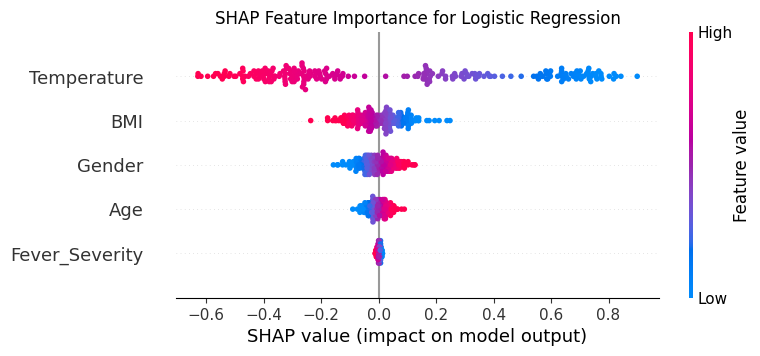

Generating SHAP explanation for Decision Tree...


<Figure size 640x480 with 0 Axes>

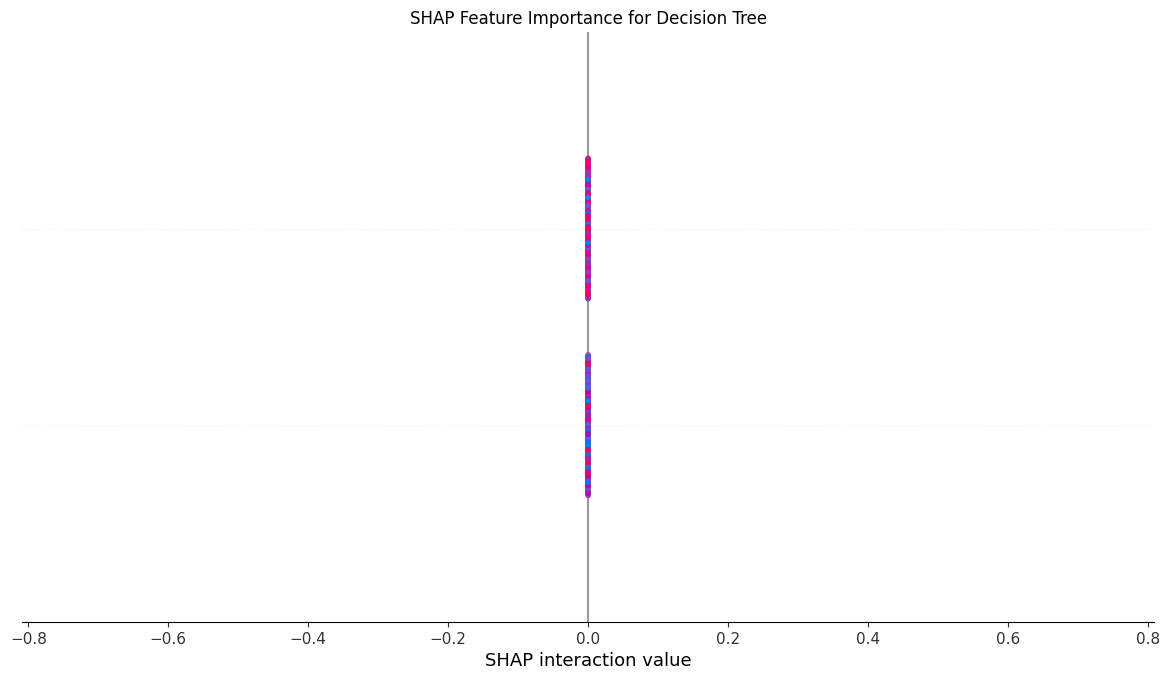

Generating SHAP explanation for Random Forest...


<Figure size 640x480 with 0 Axes>

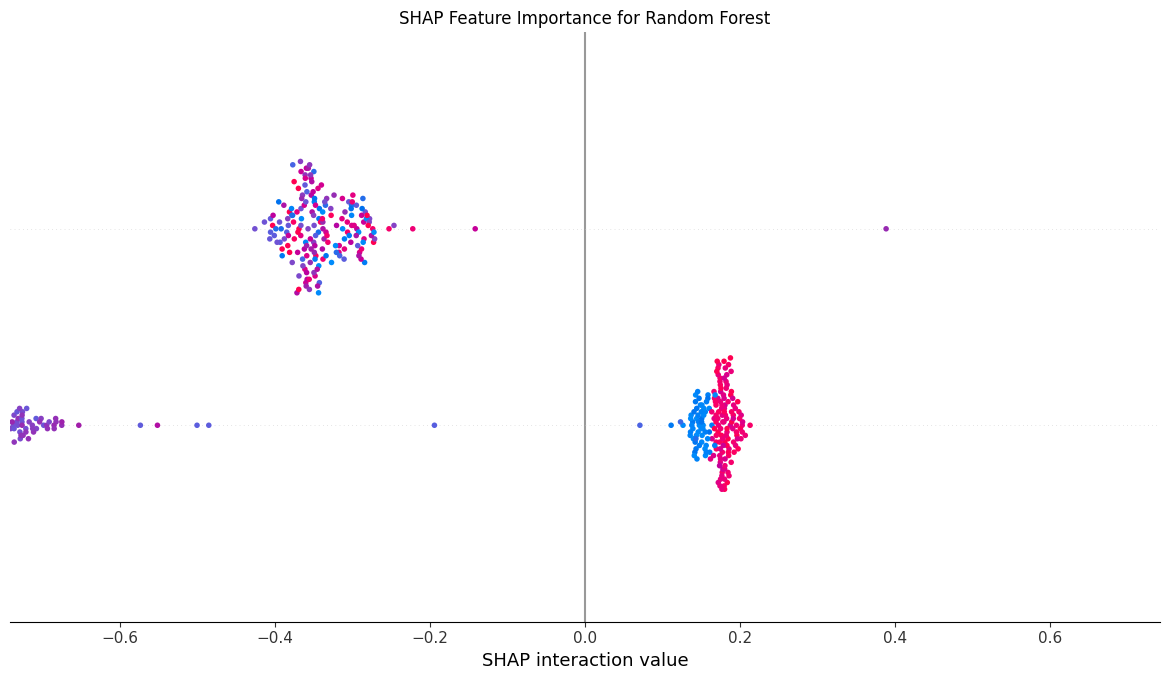

Generating SHAP explanation for XGBoost...


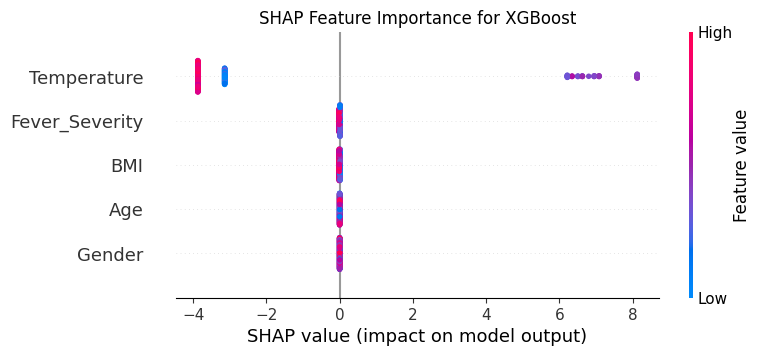

Generating SHAP explanation for Neural Network...


  0%|          | 0/229 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

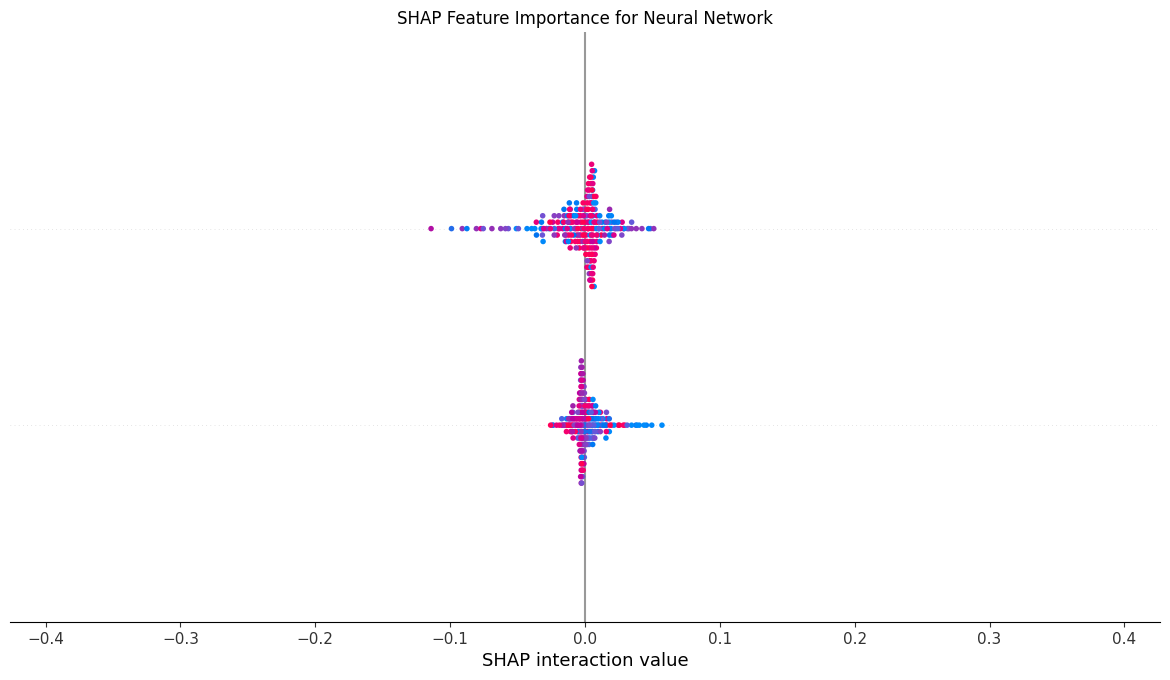

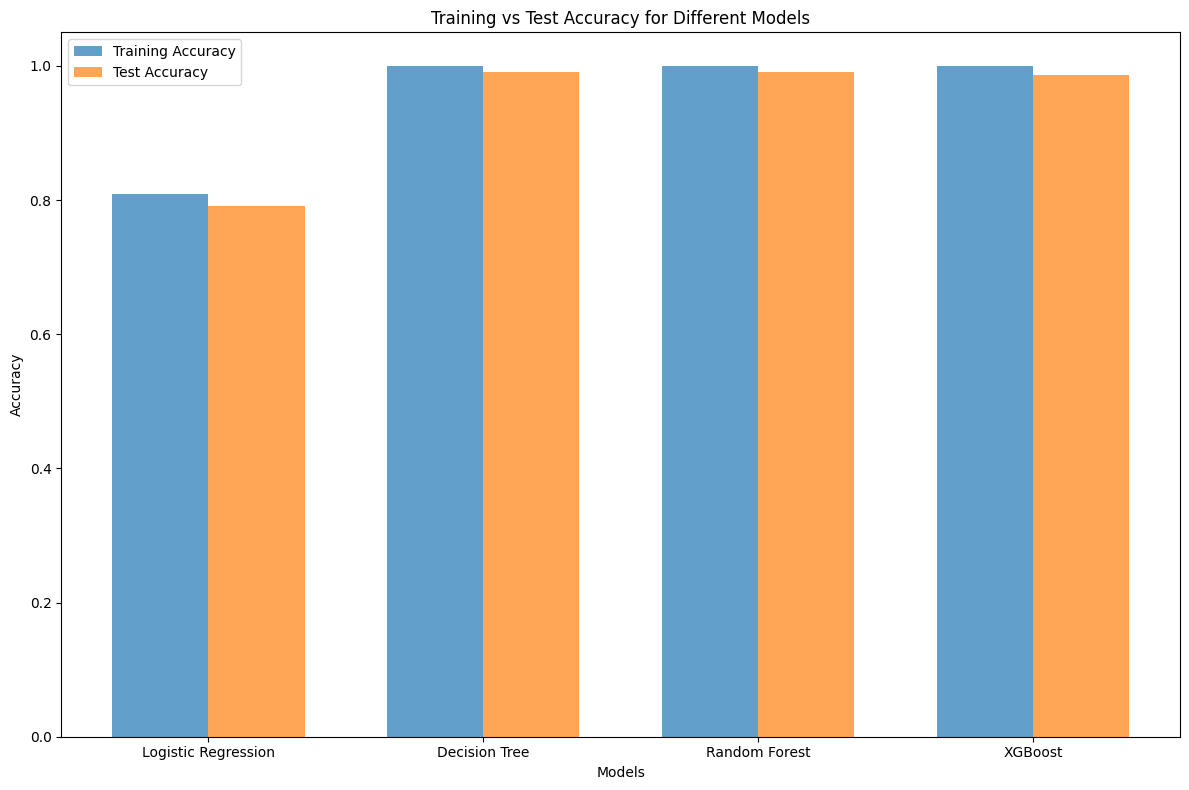

In [55]:
import matplotlib.pyplot as plt

# Train and track accuracy for each model
models = {
    'Logistic Regression': lr,
    'Decision Tree': dtre,
    'Random Forest': rndm_forest,
    'XGBoost': xgb_classifier,
}

# Create a dictionary to store explainers for each model
explainers = {
    'Logistic Regression': shap.LinearExplainer(lr, X_train),
    'Decision Tree': shap.TreeExplainer(dtre),
    'Random Forest': shap.TreeExplainer(rndm_forest),
    'XGBoost': shap.TreeExplainer(xgb_classifier),
    # 'Neural Network': shap.KernelExplainer(nn_model.predict, X_train_nn)  # For Neural Network, use KernelExplainer
    'Neural Network': shap.KernelExplainer(nn_model, X_train_nn)  # For Neural Network, use KernelExplainer

}

# Loop through models and generate SHAP explanations
for model_name, explainer in explainers.items():
    print(f"Generating SHAP explanation for {model_name}...")

    # Calculate SHAP values
    if model_name == 'Neural Network':
        shap_values = explainer.shap_values(X_test, nsamples=100) # Use X_test or other relevant data for NN
    else:
        shap_values = explainer.shap_values(X_test)  # Use X_test or other relevant data

    # Visualize feature importance
    shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)  # show=False to avoid overlapping plots
    plt.title(f"SHAP Feature Importance for {model_name}")
    plt.show()


# Create a dictionary to store training and validation accuracy
train_accuracies = {}
test_accuracies = {}

for model_name, model in models.items():
    # Fit the model on training data
    model.fit(X_train, y_train)

    # Track training and validation accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    # Store the accuracies
    train_accuracies[model_name] = train_accuracy
    test_accuracies[model_name] = test_accuracy

# Plot training and validation accuracies for each model
plt.figure(figsize=(12, 8))

# Create bars for each model's training and test accuracy
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, train_accuracies.values(), bar_width, label='Training Accuracy', alpha=0.7)
plt.bar(index + bar_width, test_accuracies.values(), bar_width, label='Test Accuracy', alpha=0.7)

# Set plot labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy for Different Models')
plt.xticks(index + bar_width / 2, models.keys())
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [56]:
# Print the accuracy for each model
for model_name in models.keys():
    print(f"{model_name} - Training Accuracy: {train_accuracies[model_name]:.5f} | Test Accuracy: {test_accuracies[model_name]:.5f}")

Logistic Regression - Training Accuracy: 0.80899 | Test Accuracy: 0.79039
Decision Tree - Training Accuracy: 1.00000 | Test Accuracy: 0.99127
Random Forest - Training Accuracy: 1.00000 | Test Accuracy: 0.99127
XGBoost - Training Accuracy: 1.00000 | Test Accuracy: 0.98690


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


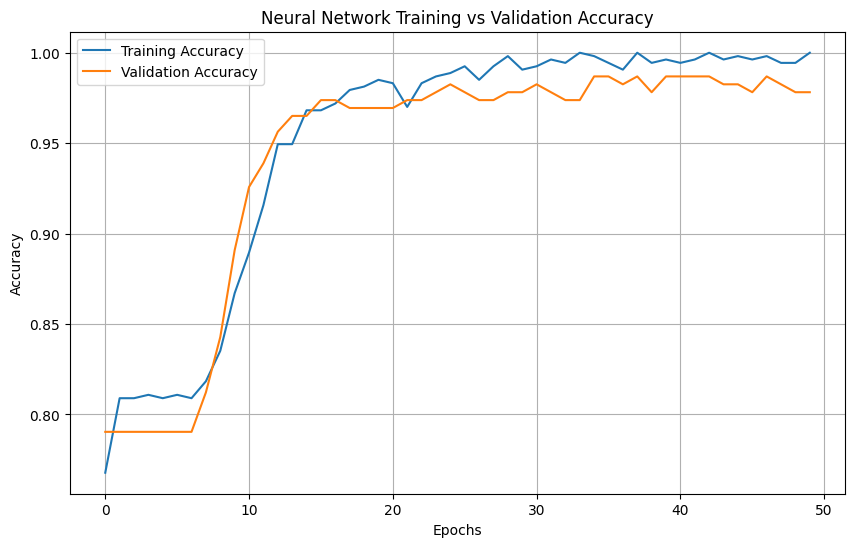

In [57]:
# Neural Network Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Encode target for NN
y_nn = le.fit_transform(y)
y_nn_categorical = to_categorical(y_nn)

# Split for NN (same PCA-transformed features)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(new_x, y_nn_categorical, test_size=0.3, random_state=42)

# Define a simple neural network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(y_nn_categorical.shape[1], activation='softmax')
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=50, batch_size=16, verbose=0)

# Plot training vs validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# Evaluate the model set
val_loss, val_accuracy = nn_model.evaluate(X_val_nn, y_val_nn)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Predict on the set
y_val_pred = nn_model.predict(X_val_nn)
y_val_pred_classes = y_val_pred.argmax(axis=1)

# Convert categorical labels to original labels
y_val_original = y_val_nn.argmax(axis=1)

# Show classification report with metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_val_original, y_val_pred_classes))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9813 - loss: 0.0291 
Validation Loss: 0.0289
Validation Accuracy: 0.9825
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       181
           1       0.98      0.94      0.96        48

    accuracy                           0.98       229
   macro avg       0.98      0.97      0.97       229
weighted avg       0.98      0.98      0.98       229

